# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
import re
from functools import partial
from math import log
from pathlib import Path

import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.populate_ipynb import CellAdder
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
fft_window_sizes = [2**x for x in range(8, 16)] + [48000]

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window) 

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band']) 
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename, 
                                    effects, 
                                    plot_points=True, 
                                    sec_ax=secax, 
                                    colors=toolbox.settings.colors, 
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_summary(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using ACI
Compiling Stan program...

Start sampling

starting worker pid=1242914 on localhost:11616 at 09:34:26.011
starting worker pid=1242929 on localhost:11616 at 09:34:26.084
starting worker pid=1242944 on localhost:11616 at 09:34:26.157
starting worker pid=1242959 on localhost:11616 at 09:34:26.233
starting worker pid=1242974 on localhost:11616 at 09:34:26.305

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000106 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000106 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.70  1.59  1.81   0.95 median hdci     
2   6.24  1.72  1.63  1.81   0.95 median hdci     
3   6.93  1.74  1.67  1.82   0.95 median hdci     
4   7.62  1.76  1.70  1.82   0.95 median hdci     
5   8.32  1.78  1.72  1.84   0.95 median hdci     
6   9.01  1.80  1.74  1.87   0.95 median hdci     
7   9.70  1.83  1.74  1.90   0.95 median hdci     
8  10.4   1.85  1.75  1.95   0.95 median hdci     
9  10.8   1.86  1.74  1.96   0.95 median hdci     



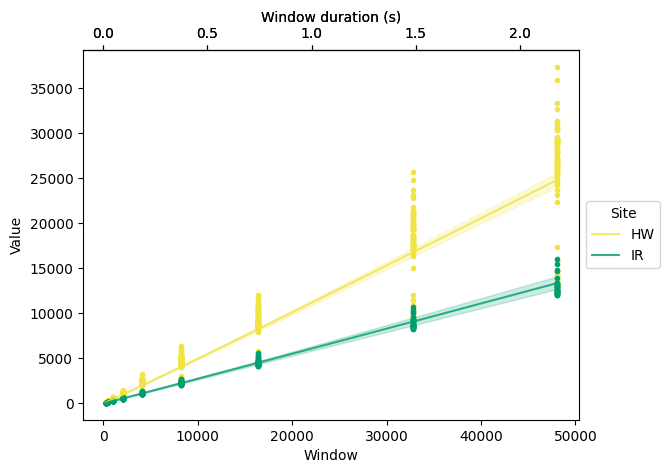

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using ADI
Compiling Stan program...

Start sampling

starting worker pid=1243213 on localhost:11616 at 09:35:16.160
starting worker pid=1243228 on localhost:11616 at 09:35:16.228
starting worker pid=1243243 on localhost:11616 at 09:35:16.297
starting worker pid=1243258 on localhost:11616 at 09:35:16.371
starting worker pid=1243273 on localhost:11616 at 09:35:16.440

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000111 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000102 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.628 0.195 1.22    0.95 median hdci     
2   6.24 0.632 0.259 1.11    0.95 median hdci     
3   6.93 0.634 0.314 1.03    0.95 median hdci     
4   7.62 0.636 0.355 0.974   0.95 median hdci     
5   8.32 0.640 0.373 0.954   0.95 median hdci     
6   9.01 0.647 0.355 0.989   0.95 median hdci     
7   9.70 0.655 0.304 1.07    0.95 median hdci     
8  10.4  0.661 0.259 1.20    0.95 median hdci     
9  10.8  0.664 0.241 1.30    0.95 median hdci     



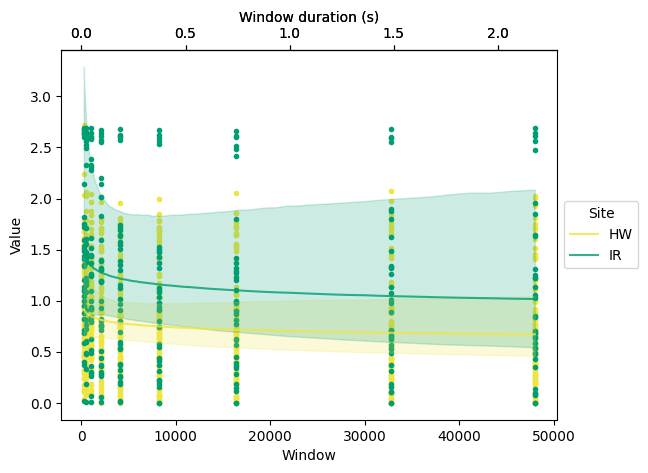

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using AEI
Compiling Stan program...

Start sampling

starting worker pid=1243489 on localhost:11616 at 09:36:06.461
starting worker pid=1243504 on localhost:11616 at 09:36:06.530
starting worker pid=1243519 on localhost:11616 at 09:36:06.597
starting worker pid=1243534 on localhost:11616 at 09:36:06.665
starting worker pid=1243549 on localhost:11616 at 09:36:06.732

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000138 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.38 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00014 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 1.4 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Wa

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256  1.07 1.06   1.09   0.95 median hdci     
2    512  1.07 1.05   1.09   0.95 median hdci     
3   1024  1.07 1.06   1.09   0.95 median hdci     
4   2048  1.07 1.05   1.09   0.95 median hdci     
5   4096  1.07 1.05   1.09   0.95 median hdci     
6   8192  1.06 1.05   1.08   0.95 median hdci     
7  16384  1.05 1.04   1.07   0.95 median hdci     
8  32768  1.03 1.01   1.05   0.95 median hdci     
9  48000  1.02 0.993  1.04   0.95 median hdci     



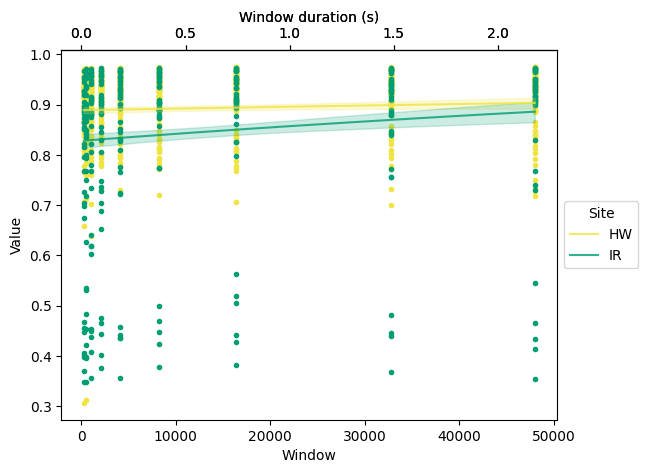

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site'],
          cross_effect='Site')


broadband using BIO
Compiling Stan program...

Start sampling

starting worker pid=1244408 on localhost:11616 at 09:40:55.419
starting worker pid=1244423 on localhost:11616 at 09:40:55.488
starting worker pid=1244438 on localhost:11616 at 09:40:55.556
starting worker pid=1244453 on localhost:11616 at 09:40:55.624
starting worker pid=1244468 on localhost:11616 at 09:40:55.693

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00024 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.4 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000234 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 2.34 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Wa

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  3.69  3.06  4.41   0.95 median hdci     
2   6.24  3.72  3.15  4.28   0.95 median hdci     
3   6.93  3.76  3.34  4.26   0.95 median hdci     
4   7.62  3.80  3.41  4.20   0.95 median hdci     
5   8.32  3.83  3.48  4.23   0.95 median hdci     
6   9.01  3.87  3.48  4.31   0.95 median hdci     
7   9.70  3.91  3.42  4.41   0.95 median hdci     
8  10.4   3.95  3.38  4.59   0.95 median hdci     
9  10.8   3.98  3.33  4.70   0.95 median hdci     



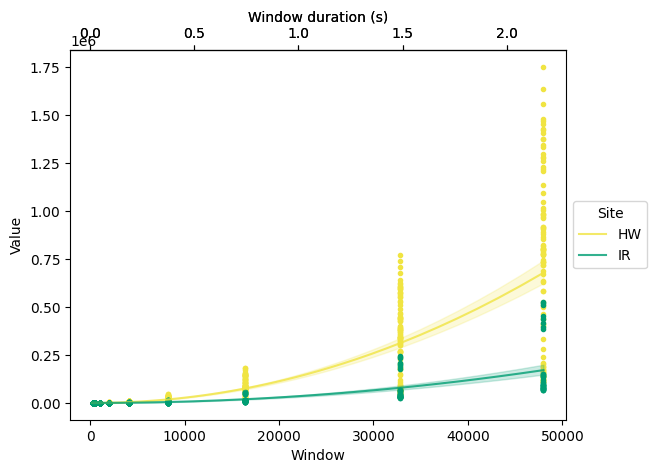

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (0, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]


In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ACI
Compiling Stan program...

Start sampling

starting worker pid=1257836 on localhost:11616 at 11:45:47.437
starting worker pid=1257851 on localhost:11616 at 11:45:47.511
starting worker pid=1257866 on localhost:11616 at 11:45:47.590
starting worker pid=1257881 on localhost:11616 at 11:45:47.665
starting worker pid=1257896 on localhost:11616 at 11:45:47.740

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000463 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 4.63 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00042 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 4.2 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Wa

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.00  1.01   0.95 median hdci     
2   6.24  1.02  1.02  1.02   0.95 median hdci     
3   6.93  1.03  1.03  1.04   0.95 median hdci     
4   7.62  1.05  1.04  1.05   0.95 median hdci     
5   8.32  1.06  1.06  1.06   0.95 median hdci     
6   9.01  1.07  1.07  1.08   0.95 median hdci     
7   9.70  1.09  1.08  1.09   0.95 median hdci     
8  10.4   1.10  1.09  1.10   0.95 median hdci     
9  10.8   1.11  1.10  1.11   0.95 median hdci     



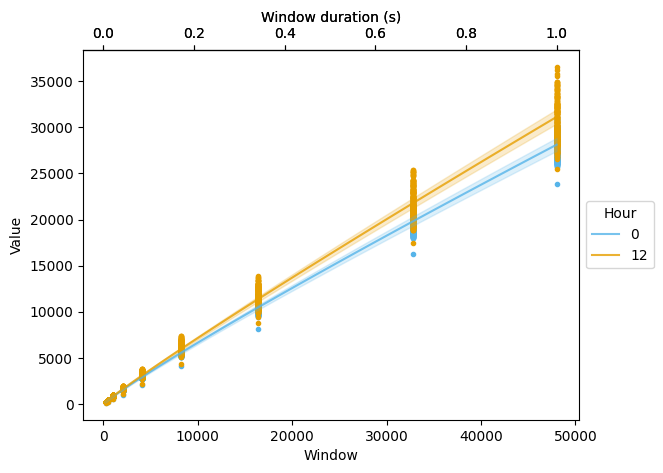

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using ACI
Compiling Stan program...

Start sampling

starting worker pid=1259103 on localhost:11616 at 11:49:10.912
starting worker pid=1259118 on localhost:11616 at 11:49:10.984
starting worker pid=1259133 on localhost:11616 at 11:49:11.060
starting worker pid=1259148 on localhost:11616 at 11:49:11.134
starting worker pid=1259163 on localhost:11616 at 11:49:11.207

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000564 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.64 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000546 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 5.46 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmu

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.931 0.923 0.940   0.95 median hdci     
2   6.24 0.942 0.935 0.949   0.95 median hdci     
3   6.93 0.953 0.947 0.959   0.95 median hdci     
4   7.62 0.964 0.959 0.969   0.95 median hdci     
5   8.32 0.975 0.971 0.980   0.95 median hdci     
6   9.01 0.987 0.982 0.992   0.95 median hdci     
7   9.70 0.998 0.992 1.00    0.95 median hdci     
8  10.4  1.01  1.00  1.02    0.95 median hdci     
9  10.8  1.02  1.01  1.02    0.95 median hdci     



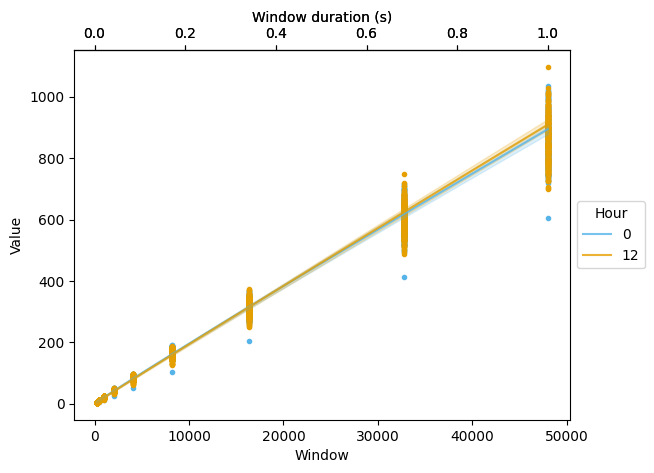

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using ACI
Compiling Stan program...

Start sampling

starting worker pid=1260120 on localhost:11616 at 11:51:12.994
starting worker pid=1260140 on localhost:11616 at 11:51:13.062
starting worker pid=1260155 on localhost:11616 at 11:51:13.132
starting worker pid=1260170 on localhost:11616 at 11:51:13.202
starting worker pid=1260187 on localhost:11616 at 11:51:13.271

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000729 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.29 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000722 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.22 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.00 0.994  1.01   0.95 median hdci     
2   6.24  1.02 1.01   1.02   0.95 median hdci     
3   6.93  1.04 1.03   1.04   0.95 median hdci     
4   7.62  1.06 1.05   1.06   0.95 median hdci     
5   8.32  1.07 1.07   1.08   0.95 median hdci     
6   9.01  1.09 1.09   1.10   0.95 median hdci     
7   9.70  1.11 1.11   1.12   0.95 median hdci     
8  10.4   1.13 1.13   1.14   0.95 median hdci     
9  10.8   1.15 1.14   1.15   0.95 median hdci     



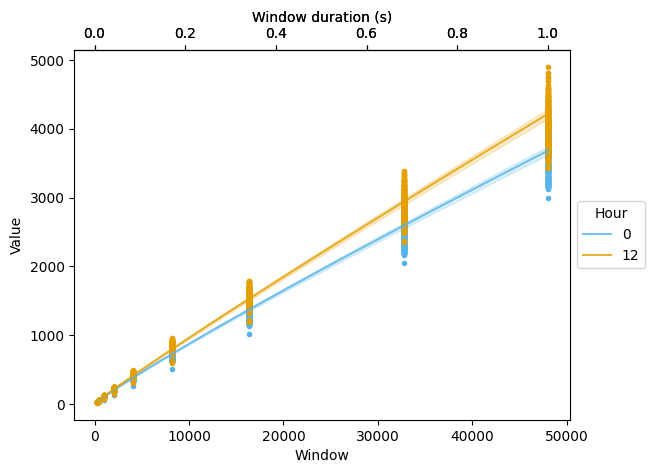

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing ACI
Compiling Stan program...

Start sampling

starting worker pid=1261362 on localhost:11616 at 11:53:56.955
starting worker pid=1261387 on localhost:11616 at 11:53:57.028
starting worker pid=1261402 on localhost:11616 at 11:53:57.099
starting worker pid=1261417 on localhost:11616 at 11:53:57.175
starting worker pid=1261432 on localhost:11616 at 11:53:57.250

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000784 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.84 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000737 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.37 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.00  1.01   0.95 median hdci     
2   6.24  1.01  1.01  1.01   0.95 median hdci     
3   6.93  1.01  1.01  1.01   0.95 median hdci     
4   7.62  1.01  1.01  1.01   0.95 median hdci     
5   8.32  1.01  1.01  1.01   0.95 median hdci     
6   9.01  1.01  1.01  1.02   0.95 median hdci     
7   9.70  1.02  1.01  1.02   0.95 median hdci     
8  10.4   1.02  1.02  1.02   0.95 median hdci     
9  10.8   1.02  1.02  1.02   0.95 median hdci     



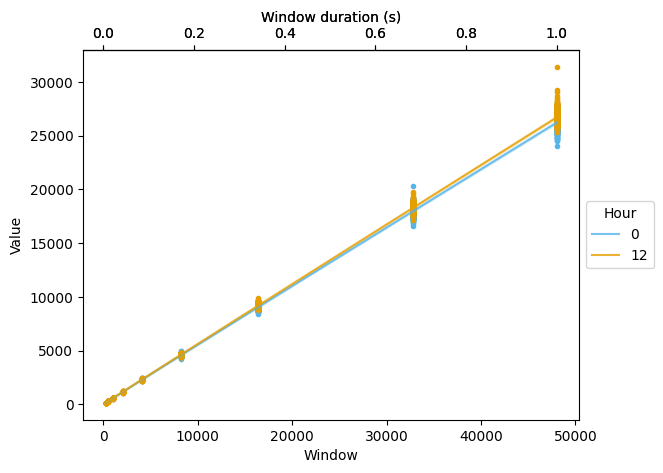

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing ACI
Compiling Stan program...

Start sampling

starting worker pid=1264370 on localhost:11616 at 12:01:53.668
starting worker pid=1264385 on localhost:11616 at 12:01:53.746
starting worker pid=1264400 on localhost:11616 at 12:01:53.819
starting worker pid=1264415 on localhost:11616 at 12:01:53.890
starting worker pid=1264430 on localhost:11616 at 12:01:53.965

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000731 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.31 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000715 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.15 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.01  1.01   0.95 median hdci     
2   6.24  1.02  1.02  1.02   0.95 median hdci     
3   6.93  1.03  1.02  1.03   0.95 median hdci     
4   7.62  1.03  1.03  1.03   0.95 median hdci     
5   8.32  1.04  1.04  1.04   0.95 median hdci     
6   9.01  1.05  1.04  1.05   0.95 median hdci     
7   9.70  1.05  1.05  1.06   0.95 median hdci     
8  10.4   1.06  1.06  1.06   0.95 median hdci     
9  10.8   1.06  1.06  1.07   0.95 median hdci     



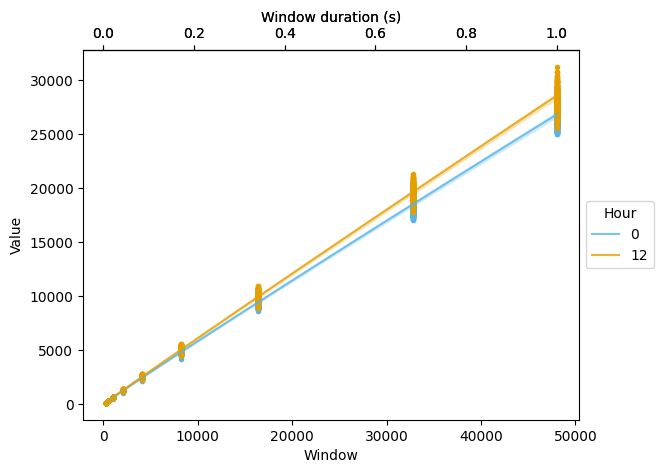

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using ADI
Compiling Stan program...

Start sampling

starting worker pid=1267158 on localhost:11616 at 12:08:38.958
starting worker pid=1267173 on localhost:11616 at 12:08:39.027
starting worker pid=1267188 on localhost:11616 at 12:08:39.097
starting worker pid=1267203 on localhost:11616 at 12:08:39.165
starting worker pid=1267218 on localhost:11616 at 12:08:39.233

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000729 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.29 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000838 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 8.38 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [42]:
print(vicky_extracted_broadband_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.06  1.05  1.07    0.95 median hdci     
2   6.24 1.04  1.04  1.05    0.95 median hdci     
3   6.93 1.03  1.02  1.04    0.95 median hdci     
4   7.62 1.02  1.01  1.02    0.95 median hdci     
5   8.32 1.00  0.999 1.01    0.95 median hdci     
6   9.01 0.991 0.986 0.996   0.95 median hdci     
7   9.70 0.978 0.972 0.985   0.95 median hdci     
8  10.4  0.965 0.958 0.973   0.95 median hdci     
9  10.8  0.958 0.950 0.967   0.95 median hdci     



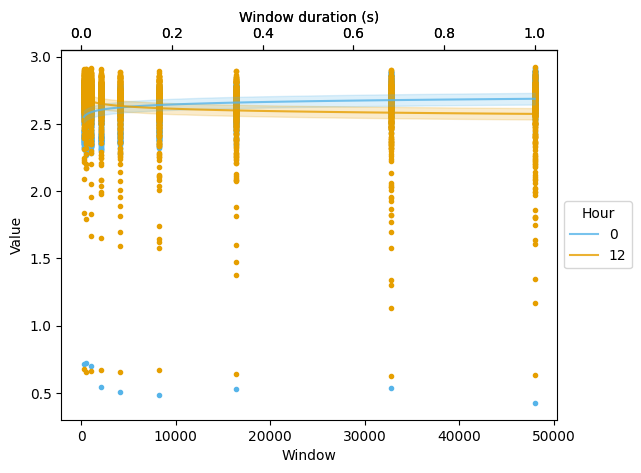

In [43]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [44]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using ADI
Compiling Stan program...

Start sampling

starting worker pid=1268108 on localhost:11616 at 12:10:39.540
starting worker pid=1268123 on localhost:11616 at 12:10:39.615
starting worker pid=1268138 on localhost:11616 at 12:10:39.692
starting worker pid=1268153 on localhost:11616 at 12:10:39.765
starting worker pid=1268168 on localhost:11616 at 12:10:39.839

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000779 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.79 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000747 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.47 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (Warmu

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [45]:
print(vicky_extracted_fish_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.998 0.993 1.00    0.95 median hdci     
2   6.24 0.993 0.989 0.997   0.95 median hdci     
3   6.93 0.989 0.985 0.992   0.95 median hdci     
4   7.62 0.984 0.981 0.987   0.95 median hdci     
5   8.32 0.980 0.977 0.982   0.95 median hdci     
6   9.01 0.975 0.972 0.978   0.95 median hdci     
7   9.70 0.971 0.967 0.974   0.95 median hdci     
8  10.4  0.966 0.962 0.970   0.95 median hdci     
9  10.8  0.964 0.959 0.968   0.95 median hdci     



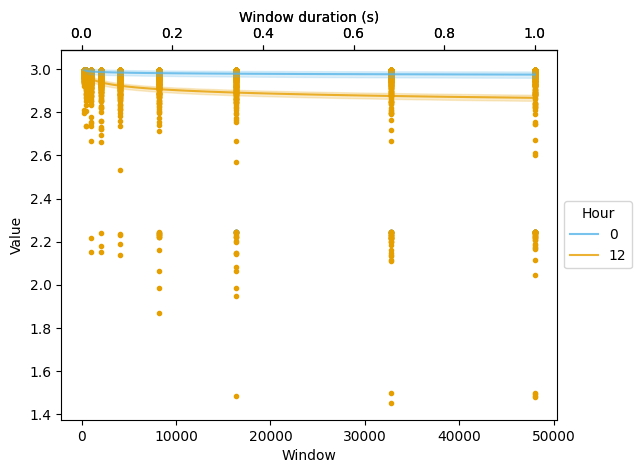

In [46]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [47]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using ADI
Compiling Stan program...

Start sampling

starting worker pid=1269375 on localhost:11616 at 12:13:33.429
starting worker pid=1269390 on localhost:11616 at 12:13:33.501
starting worker pid=1269405 on localhost:11616 at 12:13:33.575
starting worker pid=1269420 on localhost:11616 at 12:13:33.648
starting worker pid=1269435 on localhost:11616 at 12:13:33.721

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000729 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.29 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000728 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.28 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [48]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.00  1.00  1.00    0.95 median hdci     
2   6.24 1.00  1.00  1.00    0.95 median hdci     
3   6.93 1.00  1.00  1.00    0.95 median hdci     
4   7.62 1.00  0.999 1.00    0.95 median hdci     
5   8.32 1.00  0.999 1.00    0.95 median hdci     
6   9.01 0.999 0.998 1.00    0.95 median hdci     
7   9.70 0.999 0.998 1.00    0.95 median hdci     
8  10.4  0.998 0.997 1.00    0.95 median hdci     
9  10.8  0.998 0.996 0.999   0.95 median hdci     



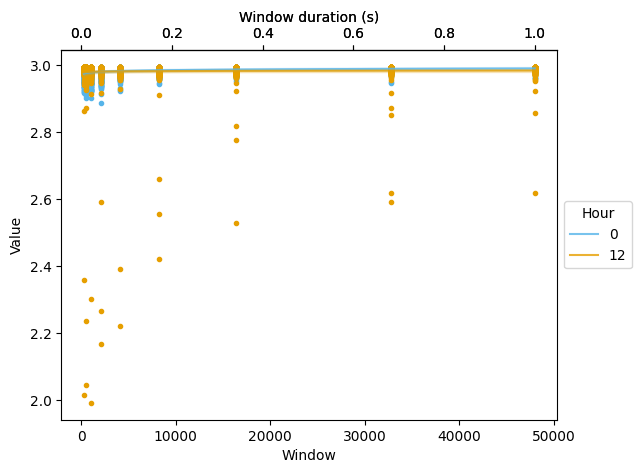

In [49]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [50]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing ADI
Compiling Stan program...

Start sampling

starting worker pid=1271242 on localhost:11616 at 12:19:57.380
starting worker pid=1271257 on localhost:11616 at 12:19:57.448
starting worker pid=1271272 on localhost:11616 at 12:19:57.520
starting worker pid=1271287 on localhost:11616 at 12:19:57.588
starting worker pid=1271302 on localhost:11616 at 12:19:57.656

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000732 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.32 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000715 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.15 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [51]:
print(vicky_filtered_fish_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.396 0.278 0.521   0.95 median hdci     
2   6.24 0.358 0.271 0.455   0.95 median hdci     
3   6.93 0.323 0.258 0.399   0.95 median hdci     
4   7.62 0.291 0.237 0.348   0.95 median hdci     
5   8.32 0.262 0.213 0.309   0.95 median hdci     
6   9.01 0.237 0.192 0.286   0.95 median hdci     
7   9.70 0.214 0.165 0.263   0.95 median hdci     
8  10.4  0.192 0.142 0.248   0.95 median hdci     
9  10.8  0.181 0.133 0.242   0.95 median hdci     



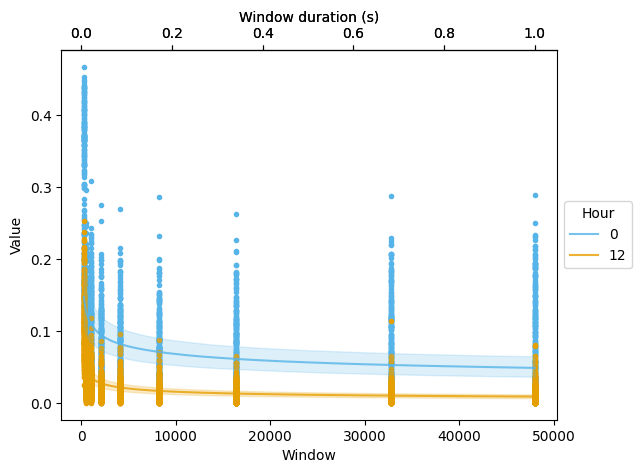

In [52]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [53]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing ADI
Compiling Stan program...

Start sampling

starting worker pid=1272308 on localhost:11616 at 12:21:20.358
starting worker pid=1272324 on localhost:11616 at 12:21:20.425
starting worker pid=1272339 on localhost:11616 at 12:21:20.493
starting worker pid=1272354 on localhost:11616 at 12:21:20.562
starting worker pid=1272369 on localhost:11616 at 12:21:20.629

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000717 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.000742 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 7.42 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [54]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 1.03  1.02  1.03    0.95 median hdci     
2   6.24 1.02  1.02  1.02    0.95 median hdci     
3   6.93 1.01  1.01  1.02    0.95 median hdci     
4   7.62 1.01  1.00  1.01    0.95 median hdci     
5   8.32 1.00  0.998 1.00    0.95 median hdci     
6   9.01 0.993 0.991 0.995   0.95 median hdci     
7   9.70 0.987 0.984 0.989   0.95 median hdci     
8  10.4  0.980 0.978 0.983   0.95 median hdci     
9  10.8  0.977 0.974 0.980   0.95 median hdci     



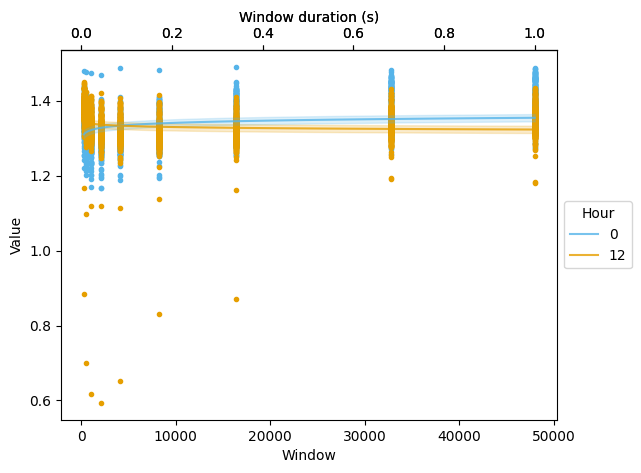

In [55]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [56]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using AEI
Compiling Stan program...

Start sampling

starting worker pid=1273881 on localhost:11616 at 12:24:46.651
starting worker pid=1273896 on localhost:11616 at 12:24:46.720
starting worker pid=1273911 on localhost:11616 at 12:24:46.788
starting worker pid=1273926 on localhost:11616 at 12:24:46.856
starting worker pid=1273941 on localhost:11616 at 12:24:46.927

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001137 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.37 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001112 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.12 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%] 

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [57]:
print(vicky_extracted_broadband_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256 0.910 0.884 0.962   0.95 median hdci     
2    512 0.912 0.885 0.963   0.95 median hdci     
3   1024 0.915 0.889 0.967   0.95 median hdci     
4   2048 0.921 0.895 0.970   0.95 median hdci     
5   4096 0.934 0.907 0.979   0.95 median hdci     
6   8192 0.959 0.937 1.00    0.95 median hdci     
7  16384 1.02  0.995 1.05    0.95 median hdci     
8  32768 1.14  1.12  1.16    0.95 median hdci     
9  48000 1.28  1.23  1.32    0.95 median hdci     



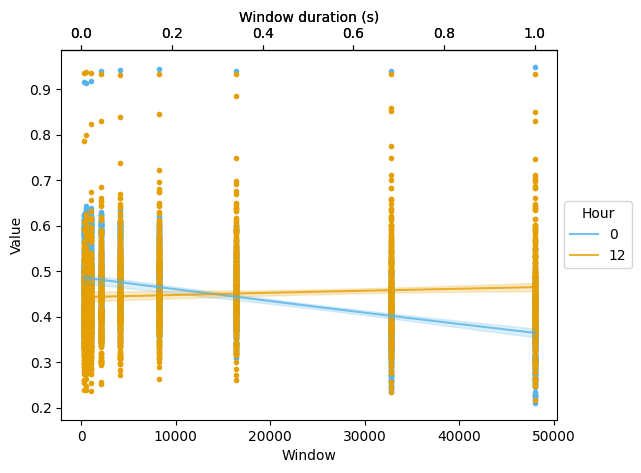

In [58]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [59]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using AEI
Compiling Stan program...

Start sampling

starting worker pid=1279432 on localhost:11616 at 12:53:21.491
starting worker pid=1279447 on localhost:11616 at 12:53:21.564
starting worker pid=1279462 on localhost:11616 at 12:53:21.636
starting worker pid=1279477 on localhost:11616 at 12:53:21.710
starting worker pid=1279492 on localhost:11616 at 12:53:21.785

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001089 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.89 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001067 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.67 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [60]:
print(vicky_extracted_fish_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256  2.05  1.92  2.18   0.95 median hdci     
2    512  2.06  1.93  2.18   0.95 median hdci     
3   1024  2.07  1.93  2.19   0.95 median hdci     
4   2048  2.08  1.95  2.20   0.95 median hdci     
5   4096  2.11  1.98  2.22   0.95 median hdci     
6   8192  2.16  2.03  2.27   0.95 median hdci     
7  16384  2.27  2.14  2.38   0.95 median hdci     
8  32768  2.52  2.36  2.68   0.95 median hdci     
9  48000  2.77  2.53  3.03   0.95 median hdci     



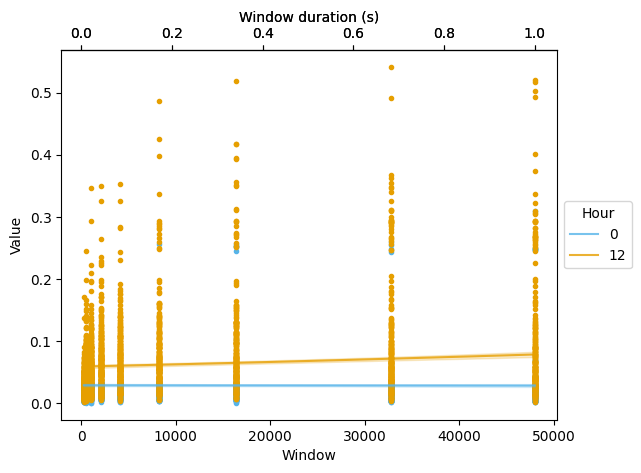

In [61]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [62]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using AEI
Compiling Stan program...

Start sampling

starting worker pid=1285273 on localhost:11616 at 13:20:06.607
starting worker pid=1285288 on localhost:11616 at 13:20:06.675
starting worker pid=1285303 on localhost:11616 at 13:20:06.744
starting worker pid=1285318 on localhost:11616 at 13:20:06.812
starting worker pid=1285333 on localhost:11616 at 13:20:06.880

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001142 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.42 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001155 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 11.55 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (W

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [63]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256 0.842 0.812 0.893   0.95 median hdci     
2    512 0.845 0.815 0.896   0.95 median hdci     
3   1024 0.851 0.821 0.902   0.95 median hdci     
4   2048 0.862 0.833 0.912   0.95 median hdci     
5   4096 0.886 0.858 0.935   0.95 median hdci     
6   8192 0.937 0.907 0.982   0.95 median hdci     
7  16384 1.05  1.01  1.09    0.95 median hdci     
8  32768 1.31  1.25  1.38    0.95 median hdci     
9  48000 1.61  1.48  1.73    0.95 median hdci     



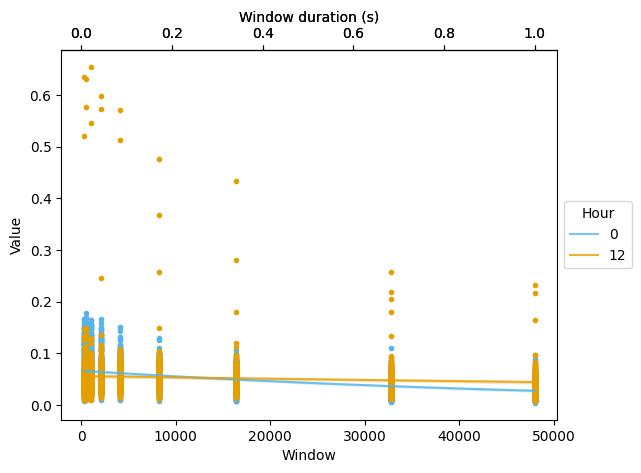

In [64]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [65]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing AEI
Compiling Stan program...

Start sampling

starting worker pid=1290142 on localhost:11616 at 13:47:44.536
starting worker pid=1290157 on localhost:11616 at 13:47:44.606
starting worker pid=1290172 on localhost:11616 at 13:47:44.680
starting worker pid=1290187 on localhost:11616 at 13:47:44.749
starting worker pid=1290202 on localhost:11616 at 13:47:44.819

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001087 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.87 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001064 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.64 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [66]:
print(vicky_filtered_fish_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256  1.01  1.00  1.01   0.95 median hdci     
2    512  1.01  1.00  1.01   0.95 median hdci     
3   1024  1.01  1.00  1.01   0.95 median hdci     
4   2048  1.01  1.00  1.01   0.95 median hdci     
5   4096  1.01  1.00  1.01   0.95 median hdci     
6   8192  1.01  1.00  1.01   0.95 median hdci     
7  16384  1.01  1.01  1.01   0.95 median hdci     
8  32768  1.01  1.01  1.01   0.95 median hdci     
9  48000  1.01  1.01  1.01   0.95 median hdci     



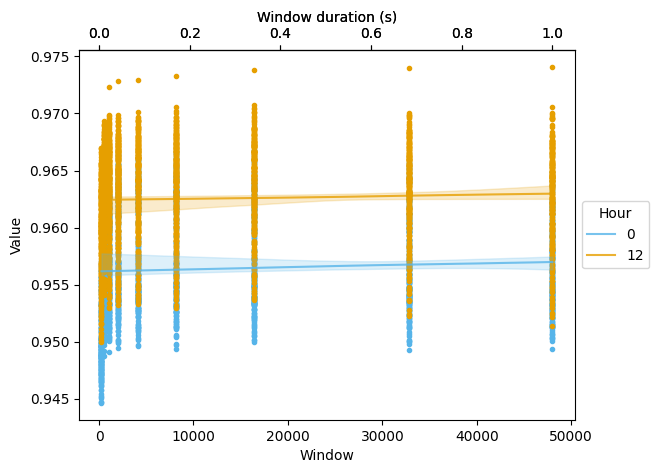

In [67]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [68]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing AEI
Compiling Stan program...

Start sampling

starting worker pid=1294466 on localhost:11616 at 14:16:00.586
starting worker pid=1294481 on localhost:11616 at 14:16:00.657
starting worker pid=1294497 on localhost:11616 at 14:16:00.732
starting worker pid=1294512 on localhost:11616 at 14:16:00.808
starting worker pid=1294527 on localhost:11616 at 14:16:00.879

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001102 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 11.02 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001095 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 10.95 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [69]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <int> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1    256 0.998 0.997  1.00   0.95 median hdci     
2    512 0.998 0.997  1.00   0.95 median hdci     
3   1024 0.999 0.997  1.00   0.95 median hdci     
4   2048 0.999 0.997  1.00   0.95 median hdci     
5   4096 0.999 0.998  1.00   0.95 median hdci     
6   8192 1.00  0.999  1.00   0.95 median hdci     
7  16384 1.00  1.00   1.00   0.95 median hdci     
8  32768 1.01  1.00   1.01   0.95 median hdci     
9  48000 1.01  1.01   1.01   0.95 median hdci     



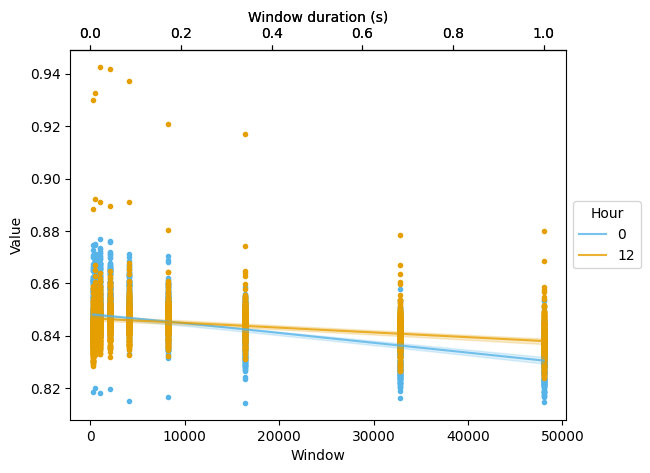

In [70]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [71]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


broadband using BIO
Compiling Stan program...

Start sampling

starting worker pid=1298645 on localhost:11616 at 14:45:01.207
starting worker pid=1298660 on localhost:11616 at 14:45:01.281
starting worker pid=1298675 on localhost:11616 at 14:45:01.357
starting worker pid=1298690 on localhost:11616 at 14:45:01.432
starting worker pid=1298705 on localhost:11616 at 14:45:01.506

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00208 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 20.8 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001902 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.02 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [72]:
print(vicky_extracted_broadband_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.885 0.873 0.899   0.95 median hdci     
2   6.24 0.888 0.878 0.900   0.95 median hdci     
3   6.93 0.891 0.883 0.900   0.95 median hdci     
4   7.62 0.895 0.887 0.902   0.95 median hdci     
5   8.32 0.898 0.891 0.904   0.95 median hdci     
6   9.01 0.901 0.893 0.908   0.95 median hdci     
7   9.70 0.904 0.895 0.913   0.95 median hdci     
8  10.4  0.907 0.897 0.919   0.95 median hdci     
9  10.8  0.909 0.897 0.921   0.95 median hdci     



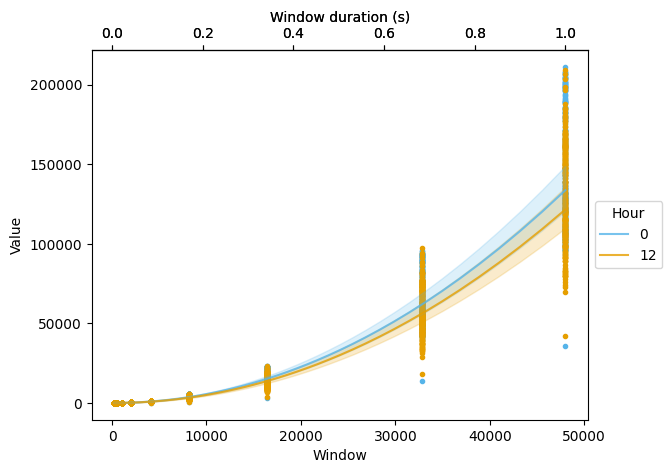

In [73]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [74]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish using BIO
Compiling Stan program...

Start sampling

starting worker pid=1300066 on localhost:11616 at 14:52:52.821
starting worker pid=1300081 on localhost:11616 at 14:52:52.890
starting worker pid=1300096 on localhost:11616 at 14:52:52.959
starting worker pid=1300111 on localhost:11616 at 14:52:53.027
starting worker pid=1300126 on localhost:11616 at 14:52:53.095

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001399 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 13.99 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001371 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 13.71 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [75]:
print(vicky_extracted_fish_BIO_ratio_summary)


# A tibble: 9 × 7
  Window        y      ymin       ymax .width .point .interval
   <dbl>    <dbl>     <dbl>      <dbl>  <dbl> <chr>  <chr>    
1   5.55 4.29e-46 0           3.12e245   0.95 median hdci     
2   6.24 5.69e-40 0           3.27e219   0.95 median hdci     
3   6.93 1.49e-37 0           2.37e205   0.95 median hdci     
4   7.62 2.17e-33 1.50e-311   1.73e190   0.95 median hdci     
5   8.32 2.64e-25 3.23e-317   5.58e193   0.95 median hdci     
6   9.01 1.60e-15 4.26e-278   2.64e222   0.95 median hdci     
7   9.70 8.31e- 3 0           4.93e240   0.95 median hdci     
8  10.4  2.26e+10 0           1.86e273   0.95 median hdci     
9  10.8  5.02e+17 3.29e-286 Inf          0.95 median hdci     



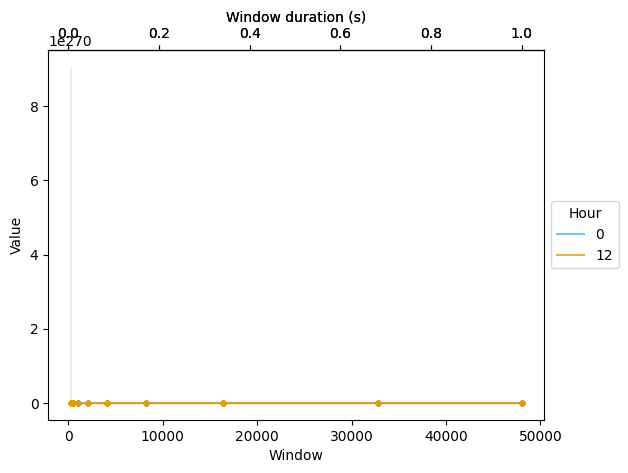

In [76]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [77]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp using BIO
Compiling Stan program...

Start sampling

starting worker pid=1300639 on localhost:11616 at 14:54:45.656
starting worker pid=1300654 on localhost:11616 at 14:54:45.726
starting worker pid=1300669 on localhost:11616 at 14:54:45.795
starting worker pid=1300684 on localhost:11616 at 14:54:45.863
starting worker pid=1300699 on localhost:11616 at 14:54:45.932

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001935 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.35 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.00197 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.7 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  0%]  (War

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [78]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.10  1.08  1.12   0.95 median hdci     
2   6.24  1.11  1.09  1.12   0.95 median hdci     
3   6.93  1.11  1.10  1.12   0.95 median hdci     
4   7.62  1.11  1.10  1.13   0.95 median hdci     
5   8.32  1.12  1.11  1.13   0.95 median hdci     
6   9.01  1.12  1.11  1.14   0.95 median hdci     
7   9.70  1.13  1.11  1.14   0.95 median hdci     
8  10.4   1.13  1.12  1.15   0.95 median hdci     
9  10.8   1.14  1.12  1.16   0.95 median hdci     



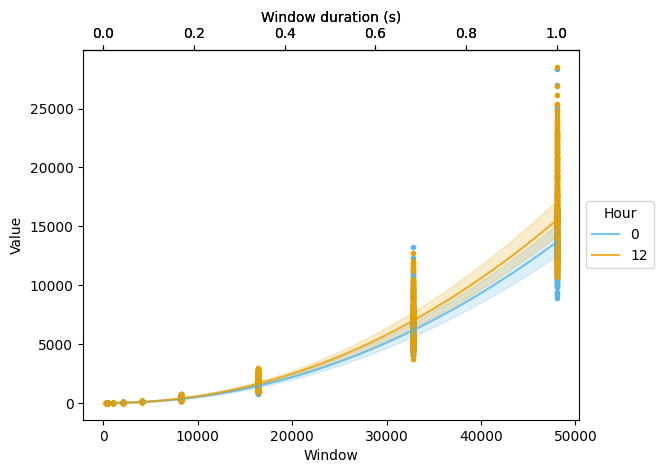

In [79]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [80]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


fish  filteredusing BIO
Compiling Stan program...

Start sampling

starting worker pid=1302299 on localhost:11616 at 15:01:20.993
starting worker pid=1302314 on localhost:11616 at 15:01:21.066
starting worker pid=1302329 on localhost:11616 at 15:01:21.138
starting worker pid=1302344 on localhost:11616 at 15:01:21.214
starting worker pid=1302359 on localhost:11616 at 15:01:21.285

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001976 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.76 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001907 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.07 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [  

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [81]:
print(vicky_filtered_fish_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55 0.975 0.971 0.980   0.95 median hdci     
2   6.24 0.956 0.953 0.960   0.95 median hdci     
3   6.93 0.938 0.935 0.941   0.95 median hdci     
4   7.62 0.919 0.917 0.922   0.95 median hdci     
5   8.32 0.902 0.899 0.904   0.95 median hdci     
6   9.01 0.884 0.882 0.886   0.95 median hdci     
7   9.70 0.867 0.864 0.869   0.95 median hdci     
8  10.4  0.850 0.847 0.853   0.95 median hdci     
9  10.8  0.841 0.837 0.844   0.95 median hdci     



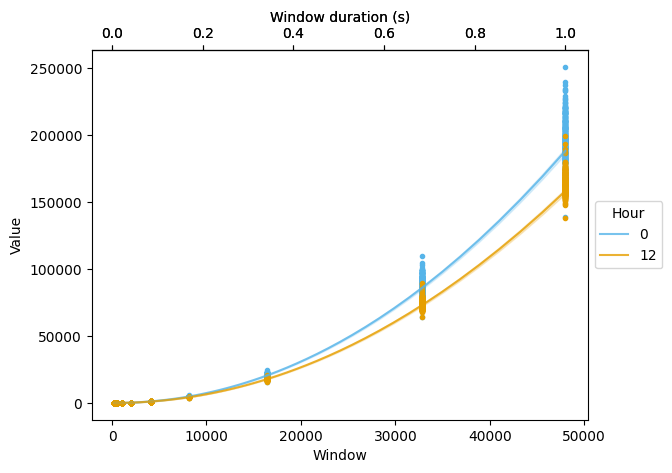

In [82]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [83]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


shrimp  filteredusing BIO
Compiling Stan program...

Start sampling

starting worker pid=1306088 on localhost:11616 at 15:10:22.888
starting worker pid=1306103 on localhost:11616 at 15:10:22.958
starting worker pid=1306118 on localhost:11616 at 15:10:23.027
starting worker pid=1306133 on localhost:11616 at 15:10:23.096
starting worker pid=1306148 on localhost:11616 at 15:10:23.166

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001933 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 19.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 2).
Chain 2: 
Chain 2: Gradient evaluation took 0.001945 seconds
Chain 2: 1000 transitions using 10 leapfrog steps per transition would take 19.45 seconds.
Chain 2: Adjust your expectations accordingly!
Chain 2: 
Chain 2: 
Chain 2: Iteration:    1 / 3000 [

/home/00112847/code/index_sensitivity/tools/plots.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in point_df.groupby(effect_names[1]):
/home/00112847/code/index_sensitivity/tools/plots.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for var_id, group in df.groupby(effect_names[1]):


In [84]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


# A tibble: 9 × 7
  Window     y  ymin  ymax .width .point .interval
   <dbl> <dbl> <dbl> <dbl>  <dbl> <chr>  <chr>    
1   5.55  1.01  1.01  1.02   0.95 median hdci     
2   6.24  1.01  1.01  1.02   0.95 median hdci     
3   6.93  1.02  1.01  1.02   0.95 median hdci     
4   7.62  1.02  1.02  1.02   0.95 median hdci     
5   8.32  1.02  1.02  1.02   0.95 median hdci     
6   9.01  1.02  1.02  1.03   0.95 median hdci     
7   9.70  1.03  1.02  1.03   0.95 median hdci     
8  10.4   1.03  1.02  1.03   0.95 median hdci     
9  10.8   1.03  1.03  1.03   0.95 median hdci     



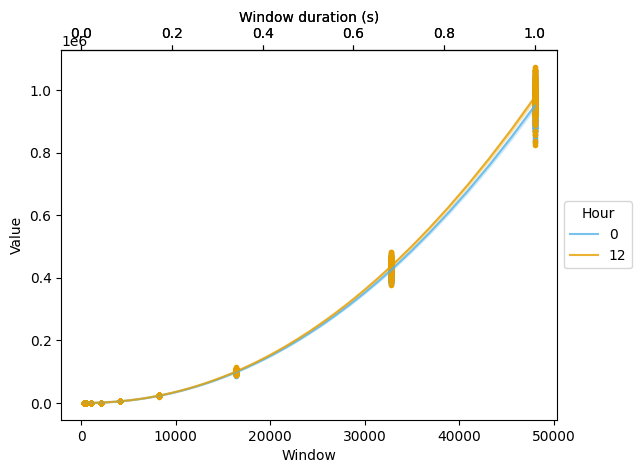

In [85]:
vicky_filtered_shrimp_BIO_fig
